In [1]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
from scipy.stats import linregress

In [2]:
data_path = "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project/"
project = signac.get_project(data_path)

In [3]:
def atom_type_pos(frame, atom_types): 
    positions = []
    for idx, type_id in enumerate(frame.particles.typeid):
        if frame.particles.types[type_id] in atom_types:
            positions.append(frame.particles.position[idx])
    return positions


def rdf_from_gsd(rdf_path, 
                 atom_types='all', 
                 r_max = None, 
                 r_min= 0.1, 
                 nbins= 50, 
                 start= 95):
    
    try: 
        f = gsd.pygsd.GSDFile(open(rdf_path, "rb"))
    except PermissionError:
        print("problem with", rdf_path)
        return None
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    if r_max is None:
        r_max = max(trajectory[-1].configuration.box[:3]) * 0.45
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    if len(trajectory[start:]) <1: 
        print('two fewer frames')
        return None
    for frame in trajectory[start:-10]:
        if atom_types == 'all':
            freud_rdf.compute(frame, reset=False)
        else:
            query_points = atom_type_pos(frame, atom_types)
            box = frame.configuration.box
            freud_rdf.compute(system=(box, query_points), reset=False)
            
    x = freud_rdf.bin_centers
    y = freud_rdf.rdf
    #Be aware of atom type naming with multiple atom types in function
    filename = job.fn('{}-trajectory-gwen.txt'.format(atom_types[0]))
    np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
    f.close()
    #print("it worked")
    return freud_rdf

def msd_slope(job, step_size = 2, atom_types='all'):  
    msd = np.genfromtxt(job.fn('msd.log'), names=True, delimiter="\t")
    x = msd['timestep'][-3000::step_size]
    y = msd[atom_types][-3000::step_size]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return x, y, slope


In [6]:
def rdf_analysis(job_list):
    for job in job_list:
        rdf_path= job.fn('trajectory.gsd')
        rdf_from_gsd(rdf_path, atom_types= ['f'], start =0)
        txt_path= job.fn('f-trajectory-gwen.txt')
    line= np.genfromtxt(txt_path, names=True, delimiter=",")
    x= line["bin_centers"]
    y= line["rdf"]
    plt.title("PTB7 fluorine at %skT %sden" % (job.sp['kT_reduced'], job.sp['density']), fontsize=16)
    plt.xlabel("distance r (A.U.)", fontsize=14)
    plt.ylabel("G(r)", fontsize=14)
    plt.plot(x, y)



def msd_constant_temperature(kT_reduced, den_min, den_max, polymer_length=None):
    state_dict = {"size": "small",
              "process": "quench",
              "kT_reduced":kT_reduced}
    if polymer_length:
        state_dict["molecule"] = "PTB7_{}mer_smiles".format(polymer_length)
    job_list = project.find_jobs(state_dict)
    slope_values = []
    fig = plt.figure()
    ax = plt.subplot(111)
    for job in job_list:
        if den_min <= job.sp['density'] <= den_max:
            x, y, slope = msd_slope(job)
            ax.plot(x, y, label=job.sp['density'])
            slope_values.append(slope)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.title("MSD of PTB7 temperatures at %sden" % (job.sp['density']))
    plt.xlabel("timestep", fontsize=14)
    plt.ylabel("msd", fontsize=14)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    handles,labels = ax.get_legend_handles_labels()
    as_float = [float(i) for i in labels]
    order = np.argsort(as_float)
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax.legend(handles,labels,loc=2)
    plt.show()

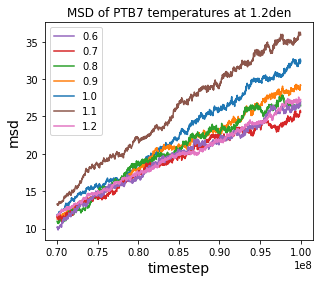

In [7]:
msd_constant_temperature(kT_reduced=1.3,
                      polymer_length=5,
                      den_min=0.6,
                      den_max=1.2)